## The answer to question 1

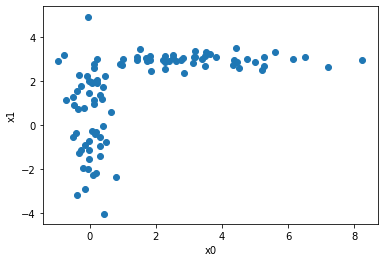

In [4]:
%matplotlib inline
import numpy as np
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt

# Part 1:

# number of samples per cluster
pts = 50

# random number generator
rng = np.random.default_rng()

a = rng.multivariate_normal(
    mean=[0,0],
    cov=[[0.08,0],
         [0,4]],
    size=pts,
)

b = rng.multivariate_normal(
    mean=[3,3],
    cov=[[4,0],
         [0,0.08]],
    size=pts,
)

x = np.concatenate((a, b))

# Plot data
plt.scatter(x[:, 0], x[:, 1])
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()


## The answer to question 2


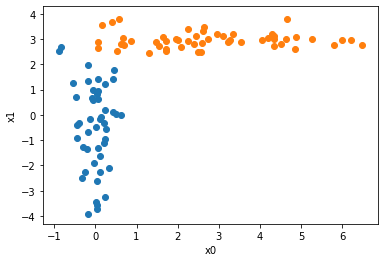

In [5]:
import numpy as np
from scipy.spatial.distance import cdist
from matplotlib import pyplot as plt

# number of samples per cluster
pts = 50

# random number generator
rng = np.random.default_rng()

a = rng.multivariate_normal(
    mean=[0,0],
    cov=[[0.08,0],
         [0,4]],
    size=pts,
)

b = rng.multivariate_normal(
    mean=[3,3],
    cov=[[4,0],
         [0,0.08]],
    size=pts,
)

x = np.concatenate((a, b))

def kmeans(x, k, no_of_iterations):

    """ Function to implement k-means clustering
    # x is a (num_samples, 2) numpy array
    # k is number of clusters
    # no_of_iterations is the number of iterations to run k means
    """

    # Randomly choose initial Centroids
    idx = np.random.choice(len(x), k, replace=False)

    centroids = x[idx, :]
    distances = cdist(x, centroids ,'euclidean')
    points = np.array([np.argmin(i) for i in distances])

    # main loop
    for _ in range(no_of_iterations):

        centroids = []

        for idx in range(k):
            temp_cent = x[points==idx].mean(axis=0)
            centroids.append(temp_cent)
        centroids = np.vstack(centroids)
        distances = cdist(x, centroids ,'euclidean')
        points = np.array([np.argmin(i) for i in distances])

    return points

# use function
points = kmeans(x,k=2,no_of_iterations=10)

# assign clusters
cluster1 = x[points==0]
cluster2 = x[points==1]

# Plot the data in labeled clusters
plt.scatter(cluster1[:, 0], cluster1[:, 1])
plt.scatter(cluster2[:, 0], cluster2[:, 1])
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

## The answer to question 3 - Part 1 (ZeroR)
We analyze the ZeroR on the given dataset.


In [6]:
from fileIO import get_file
labels = {'sentimental': 0, 'afraid': 1, 'proud': 2, 'faithful': 3, 'terrified': 4, 'joyful': 5,
          'angry': 6, 'sad': 7, 'jealous': 8, 'grateful': 9, 'prepared': 10, 'embarrassed': 11, 'excited': 12,
          'annoyed': 13, 'lonely': 14, 'ashamed': 15, 'guilty': 16, 'surprised': 17, 'nostalgic': 18,
          'confident': 19, 'furious': 20, 'disappointed': 21, 'caring': 22, 'trusting': 23, 'disgusted': 24,
          'anticipating': 25, 'anxious': 26, 'hopeful': 27, 'content': 28, 'impressed': 29, 'apprehensive': 30,
          'devastated': 31}

prompt_train, response_train, labels_train, prompt_val, response_val, labels_val = get_file()
D_train = {}

max_val = -1
max_label = -1
for i in labels_train:
    if i not in D_train:
        D_train[i] = 1
    else:
        D_train[i] += 1
    val = D_train[i]
    if val> max_val:
        max_val = val
        max_label = i

print(max_val,max_label,"out of:", len(labels_train))
acc = 0
for i in labels_val:
    if max_label == i:
        acc+=1
print("Correct for ZeroR is:", acc, " out of:", len(labels_val), "%"+str(acc/len(labels_val)*100))

Reading data started finished ...
Reading data finished ...
4310 surprised out of: 84169
Correct for ZeroR is: 641  out of: 12078 %5.3071700612684225


## The answer to question 3 - Part 2 (Main Code)



In [ ]:
import os
import sys

import torch

import torch.nn.functional as F
from torch import nn

from FinalSubmission.custom_dataset import tokenizer, Dataset
from FinalSubmission.fileIO import get_file
from FinalSubmission.gpt2_model import model
from tqdm import tqdm


def cross_entropy_loss(logits, target_ids):
    """
    For F.cross_entropy the Input is shape (N, C), where N = batch_size x sequence_length
    and C is the number of classes, in our case C is the number of tokens in the vocabulary
    Target is shape (N).

    https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html

    we flatten the batch dimension together with the max_seq length
    so that for the loss funstion, so afterwards, there is no batch dimension,
    just a vector sized C-dimensions for each of the seq_len tokens.
    If there had been 2 sampels with a batch size of 2, with 3 tokens in each sample
    then the predictions.shape would be torch.Size([6, 50257])

    Args:
        logits (torch.tensor, float): shape [batch_size, sequence_length, vocab_size]
        target_ids (torch.tensor, int): shape [batch_size, sequence_length]

    Returns:
        scalar_loss (torch.tensor, scalar float, grad_fn=<NllLossBackward0>)): no shape
            this is a loss you can backpropagate using:

            optimizer.zero_grad()
            scalar_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

    """

    predictions = logits.view(-1, logits.size(-1))
    target = target_ids.view(-1)

    scalar_loss = F.cross_entropy(
        predictions,
        target,
    )

    return scalar_loss


class BaseAgent(torch.nn.Module):

    def __init__(self, tokenizer, model, device=-1):

        super().__init__()

        self.model = model
        self.tokenizer = tokenizer
        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, betas=(0.9, 0.98), eps=1e-9,)

        self.num_gpus = torch.cuda.device_count()
        """
        if self.num_gpus > 1:
            self.model.parallelize()
        elif self.num_gpus == 1:
            self.model = self.model.cuda()"""
        #for plots
        self.x_epoch = []
        self.y_loss = {"train":[],"val":[]}
        self.y_acc = {"val":[],"SentCompletion":[]}

        # handle GPU better
        if device == -1:
            use_cuda = torch.cuda.is_available()
            self.device = torch.device("cuda" if use_cuda else "cpu")
        else:
            self.device = device
        self.model = self.model.to(self.device )#.cuda()


    def draw_curve(self, current_epoch):
        import matplotlib.pyplot as plt
        fig = plt.figure()
        ax0 = fig.add_subplot(121, title="loss")
        ax1 = fig.add_subplot(122, title="accuracy")

        ax0.plot(self.x_epoch, self.y_loss['train'], 'bo-', label='train')
        ax0.plot(self.x_epoch, self.y_loss['val'], 'ro-', label='val')
        ax1.plot(self.x_epoch, self.y_acc['val'], 'bo-', label='val')
        ax1.plot(self.x_epoch, self.y_acc['SentCompletion'], 'ro-', label='val snt compl')
        ax0.legend(loc="upper left")
        ax1.legend(loc="upper left")
        fig.savefig(os.path.join('./plots', str(current_epoch)+'_plot.png'))

    def get_response(self, prompt, max_len = 32):

        prompt_ids = self.tokenizer.encode(prompt, return_tensors="pt",)

        if self.num_gpus > 0:
            prompt_ids = prompt_ids.to(self.device)#.cuda()

        prompt_len = prompt_ids.shape[1]

        output_ids = self.model.generate(prompt_ids, max_length=prompt_len+max_len, )

        generated_text = self.tokenizer.batch_decode(output_ids)[0]

        return generated_text

    def memorize(self, prompt_train, response_train, labels_train, prompt_val, response_val, labels_val, epochs, batch_size):
        train, val = Dataset(prompt_train, response_train, labels_train), Dataset(prompt_val, response_val, labels_val)

        train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
        val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

        # allow params to be updated
        best_acc = -1
        self.model.train()
        for epoch_num in range(epochs):
            total_train_samples = 0
            total_loss_train = 0
            print("epoch", epoch_num)
            for train_input, train_label in tqdm(train_dataloader):#We dont use labels here, it was constructed on dataset itself
                prompt = ""
                for str in train_input:
                    total_train_samples += 1
                    prompt += str
                #print(prompt)
                prompt_dic = self.tokenizer(prompt, return_tensors="pt")
                prompt_ids = prompt_dic.input_ids
                prompt_mask = prompt_dic.attention_mask
                prompt_len = prompt_ids.shape[1]

                if self.num_gpus > 0:
                    prompt_ids = prompt_ids.to(self.device)#.cuda()
                    prompt_mask = prompt_mask.to(self.device)#.cuda()

                source_ids = prompt_ids[:, :-1]
                target_ids = prompt_ids[:, 1:]
                source_mask = prompt_mask[:, :-1]
                target_mask = prompt_mask[:, 1:]

                output = self.model(input_ids=source_ids, attention_mask=source_mask,)

                # used logits and target tokens to calculate the loss
                logits = output.logits

                scalar_loss = cross_entropy_loss(logits, target_ids,)
                total_loss_train += scalar_loss.item()

                # backward pass
                self.optimizer.zero_grad()
                scalar_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()

            total_val_samples = 0
            total_complete_sentences = 0
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():
                for val_input, val_label in val_dataloader:
                    prompt = ""
                    for stri in val_input:
                        original_A = stri.split("B: ")[0]
                        original_B = stri.split("B: ")[1]
                        original_lbl = original_B.split("<EMOTION_TYPE> ")[1]
                        original_lbl = original_lbl.split(" <|endoftext|>")[0]
                        predict_B = self.get_response(original_A+"B: ", max_len = 52)
                        predict_lbl = predict_B.split("<EMOTION_TYPE> ")
                        if len(predict_lbl)>1:
                            predict_lbl = predict_lbl[1]
                            predict_lbl = predict_lbl.split(" <|endoftext|>")
                            if len(predict_lbl)>1:
                                predict_lbl = predict_lbl[0]
                                total_complete_sentences += 1
                                if predict_lbl == original_lbl:
                                    total_acc_val += 1
                        #print(original_A, original_B, predict_B,"\n",original_lbl,predict_lbl)
                        total_val_samples += 1
                        prompt += stri
                    prompt_dic = self.tokenizer(prompt, return_tensors="pt")
                    prompt_ids = prompt_dic.input_ids
                    prompt_mask = prompt_dic.attention_mask
                    prompt_len = prompt_ids.shape[1]

                    if self.num_gpus > 0:
                        prompt_ids = prompt_ids.to(self.device)#.cuda()
                        prompt_mask = prompt_mask.to(self.device)#.cuda()

                    source_ids = prompt_ids[:, :-1]
                    target_ids = prompt_ids[:, 1:]
                    source_mask = prompt_mask[:, :-1]
                    target_mask = prompt_mask[:, 1:]

                    output = self.model(input_ids=source_ids, attention_mask=source_mask,)

                    # used logits and target tokens to calculate the loss
                    logits = output.logits

                    scalar_loss = cross_entropy_loss(logits, target_ids,)

                    total_loss_val += scalar_loss.item()
                    print("total_loss_val",total_loss_val)

            if total_complete_sentences == 0:
                total_complete_sentences = 1
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / total_train_samples: .3f} \
                        | Val Loss: {total_loss_val / total_val_samples: .3f} \
                        | Total val complete sentences: {total_complete_sentences: .3f} \
                        | Total val samples: {total_val_samples: .3f} \
                        | Val Loss: {total_loss_val / total_val_samples: .3f} \
                        | Val Accuracy: {total_acc_val / total_complete_sentences: .3f}')
            #if only save the best, take out the comment
            if True:#best_acc < total_acc_val / total_complete_sentences:
                best_acc = total_acc_val / total_complete_sentences
                print("Saving the model on epoch", epoch_num, "best accuracy is:", best_acc)
                torch.save(model.state_dict(), "gpt2_model.pth")
            #this is for the plots
            self.x_epoch.append(epoch_num)
            self.y_loss["train"].append(total_loss_train / total_train_samples)
            self.y_loss["val"].append(total_loss_val / total_val_samples)
            self.y_acc["val"].append(total_acc_val / total_complete_sentences)
            self.y_acc["SentCompletion"].append(total_complete_sentences)
            if epoch_num%10==0:
                self.draw_curve(epoch_num)
        self.draw_curve(epochs-1)

#to train take out the comment out to run the server puy them in comment
"""
ba = BaseAgent(tokenizer, model,device = 2)
prompt_train, response_train, labels_train, prompt_val, response_val, labels_val = get_file(2000,200)
ba.memorize(prompt_train, response_train, labels_train, prompt_val, response_val, labels_val,100, 10)"""



The code provides two types of metrics the 'loss' is for normal train and validation loss. The accuracy provides two metrics one is how many sentences are completed and the other if those sentences had the same sentiment. Because I didnt have time to complete the training on all data the second type is not that much but the sentence accuracy goes as expected.

Epoch 0
![0_plot](plots/0_plot.png)
Epoch 10
![10_plot](plots/10_plot.png)
Epoch 20
![20_plot](plots/20_plot.png)
Epoch 30
![30_plot](plots/30_plot.png)
Epoch 40
![40_plot](plots/40_plot.png)
Epoch 50
![50_plot](plots/50_plot.png)
Epoch 60
![60_plot](plots/60_plot.png)
Epoch 70
![70_plot](plots/70_plot.png)
Epoch 80
![80_plot](plots/80_plot.png)
Epoch 90
![90_plot](plots/90_plot.png)
Epoch 99
![99_plot](plots/99_plot.png)


## Extra credit - Creating a client-server chatbot


In [ ]:
import json

import numpy as np
from flask import Flask, request, jsonify
from flask_cors import CORS
import torch


# load the model once
from FinalSubmission.Part3_main import BaseAgent
from FinalSubmission.custom_dataset import tokenizer
from FinalSubmission.gpt2_model import model


model.load_state_dict(torch.load("gpt2_model.pth"))
model.eval()


ba = BaseAgent(tokenizer, model,device = 2)

def run_test(text):
    predict_B = ba.get_response("A: "+ text + "B: ", max_len=52)
    predict_lbl = predict_B.split("B: ")
    if len(predict_lbl)>1:
        predict_lbl = predict_lbl[1]
        predict_lbl = predict_lbl.split("<EMOTION_TYPE> ")
        if len(predict_lbl)>1:
            predict_lbl = predict_lbl[0]
    predict_lbl = "".join(predict_lbl)
    result = predict_lbl
    return result


app = Flask(__name__)
cors = CORS(app)


# Create the receiver API POST endpoint:
@app.route("/receiver", methods=["POST"])
def postME():
    # get the data from client, run it through NN classifier, return the result in a json file to client
    data = request.get_json()
    data = run_test(json.dumps(data))
    data = jsonify(data)
    return data


if __name__ == "__main__":
    app.run(debug=True)

The html client can connect to the server. This shows that bot (julia) answers correctly to the sentiment.
![title](plots/img.png)
Following is the html file for the client.

In [ ]:
<!DOCTYPE html>
<html>

<head>
    <title>
        Chatbot
    </title>
</head>

<body style="text-align:center;">

    <h1 style="color:green;">
        Welcome!
    </h1>

    <h4>
         input text:
    </h4>

    <textarea id = "input_sequence" name = "sequence" rows = "6" cols = "40" style="border:solid 1px black;"></textarea>

    <br>

    <label id = "LBL">
        Click the Button
    </label>

    <br>

    <button onclick="getLabel()">
        Click Here!
    </button>

    <script>
        function getLabel() {
            document.getElementById('LBL').innerHTML  = 'Wait for 60 seconds ...';
            fetch("http://127.0.0.1:5000/receiver",
        {
            method: 'POST',
            headers: {
                'Content-type': 'application/json',
                'Accept': 'application/json'
            },
        // Strigify the payload into JSON:
        body:JSON.stringify(document.getElementById("input_sequence").value)}).then(res=>{
                if(res.ok){
                    return res.json()
                }else{
                    alert("something is wrong")
                }
            }).then(jsonResponse=>{

                document.getElementById('LBL').innerHTML  = 'Julia: ' + jsonResponse;
                console.log(jsonResponse)
            }
            ).catch((err) => console.error(err));

        }
    </script>
</body>

</html>